# Projective Transformation
*  Compensates for scanning distortions, i.e., can be used with floorplans scanned using a smartphone camera.
*  Can work with the original floorplan (without straightened lines).
*  Requires four (or more) reference points to work reliably.

In [2]:
%matplotlib inline
from utils import polygon, plot, Point, RefPoint, scale, translate, rotate, polyline2array
from IPython.display import Image
import matplotlib.pyplot as plt
import math
from skimage import io, data
import numpy as np
from skimage.transform import warp, SimilarityTransform, estimate_transform, warp_coords
from scipy.ndimage import map_coordinates

Assume we have the following floor plan in form of a raster image. This is the original distorted version of the floorplan. The distortion due to scanning is clearly visible in the upper-left corner.

Floorplan dimensions: width=1211 height=800


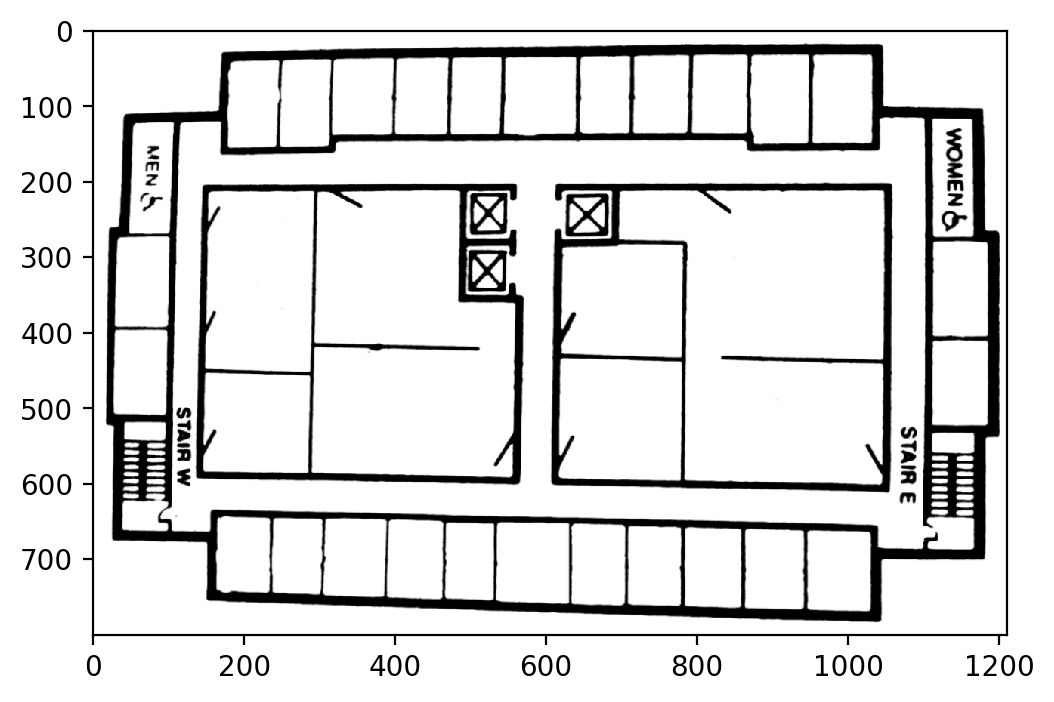

In [29]:
floorplan = io.imread('floorplan_distorted.png')
plt.imshow(floorplan)

shape = floorplan.shape
print('Floorplan dimensions: width=%d height=%d' % (shape[1], shape[0]))

I looked up the building on OpenStreetMap and made the following screenshot of building detail.

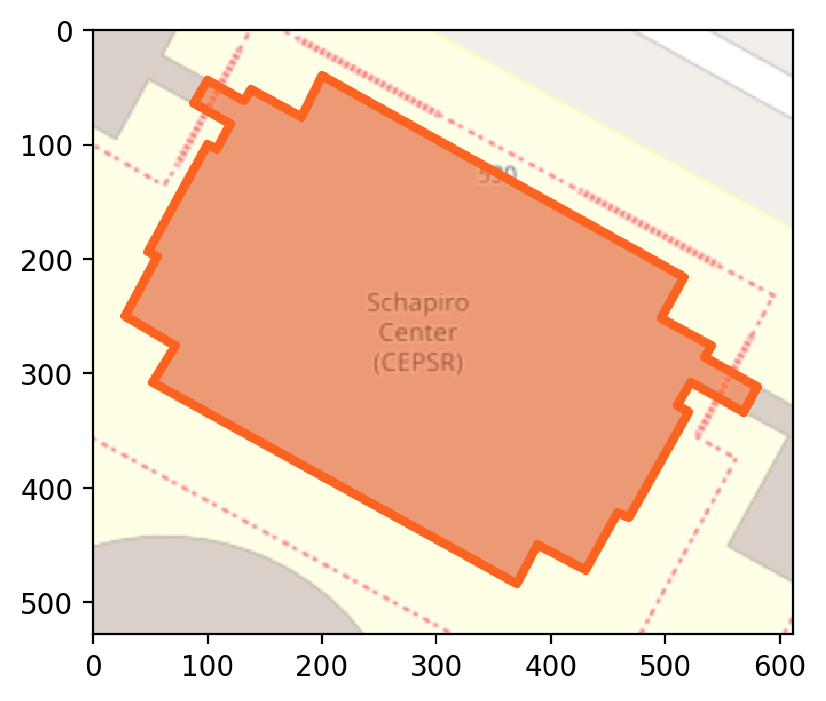

In [4]:
mapview = io.imread('cepsr_detail.png')

plt.imshow(mapview)

Next, I used a bitmap editor to find out the x,y coordinates of all building corners in both images (floorplan and map screenshot). There are 10 corners in total. The variable ref contains a reference point for each corner.

In [5]:
ref = [
    RefPoint(Point( 156, 670), Point( 69, 275)),
    RefPoint(Point( 157, 747), Point( 53, 306)),
    RefPoint(Point(1035, 775), Point(369, 482)),
    RefPoint(Point(1036, 693), Point(389, 450)),
    RefPoint(Point(1172, 692), Point(430, 471)),
    RefPoint(Point(1173, 531), Point(458, 421)),
    RefPoint(Point(1190, 529), Point(468, 424)),
    RefPoint(Point(1190, 272), Point(519, 334)),
    RefPoint(Point(1173, 270), Point(509, 328)),
    RefPoint(Point(1170, 109), Point(539, 275)),
    RefPoint(Point(1039, 106), Point(497, 250)),
    RefPoint(Point(1037,  24), Point(515, 216)),
    RefPoint(Point( 176,  33), Point(200,  40)),
    RefPoint(Point( 172, 111), Point(182,  74)),
    RefPoint(Point(  47, 115), Point(137,  52)),
    RefPoint(Point(  40, 265), Point(107, 103)),
    RefPoint(Point(  26, 266), Point(100,  99)),
    RefPoint(Point(  22, 514), Point(49,  192)),
    RefPoint(Point(  34, 516), Point(54,  198)),
    RefPoint(Point(  32, 667), Point(29,  249))
]

To double-check that the x,y coordinates are correct, let's draw the points over the images. Reference point with index 0 is highlighed in blue. Reference points are counted counter clockwise.

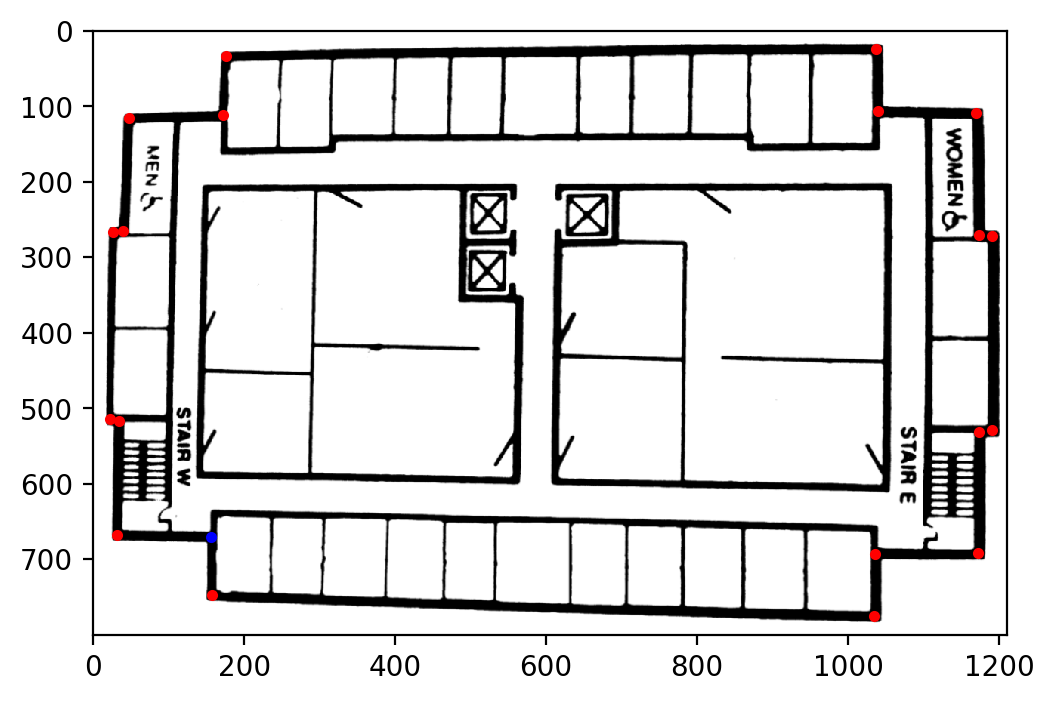

In [6]:
plt.imshow(floorplan)
i = 0
for r in ref:
    plt.plot(*r.old, color="blue" if i == 0 else "red", marker='o', markersize=3)
    i = i + 1

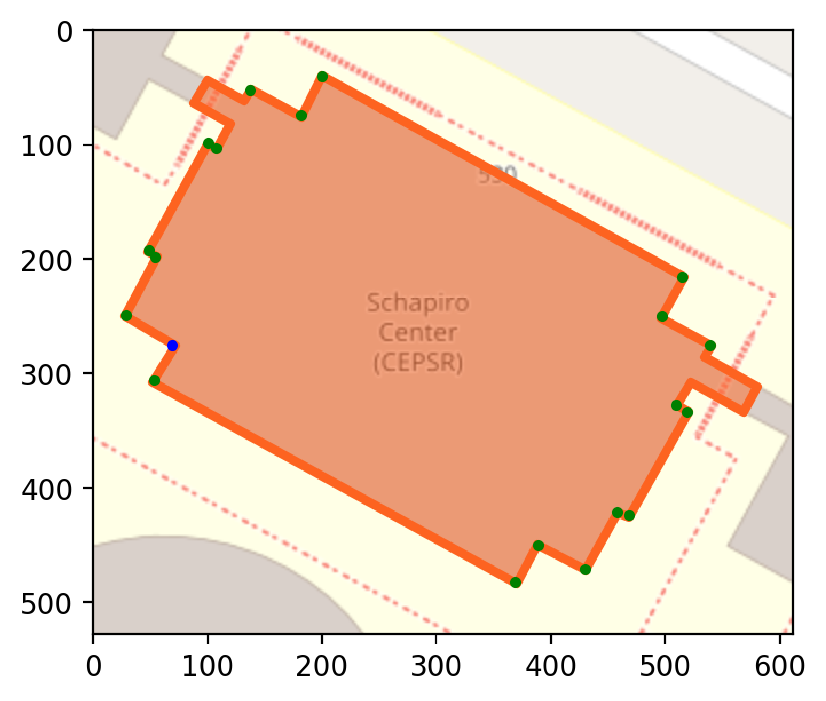

In [7]:
plt.imshow(mapview)
i = 0
for r in ref:
    plt.plot(*r.new, color="blue" if i == 0 else "green", marker='o', markersize=3)
    i = i + 1

First, let's try to use two reference points to transform the floorplan image into the reference frame of the mapview. We plot the transformed floorplan over the mapview to see the result. This method very closely resembles the transformation that Alex's Java application is doing. Thus, the result that we get here will be very similar to what the Java application would provide.

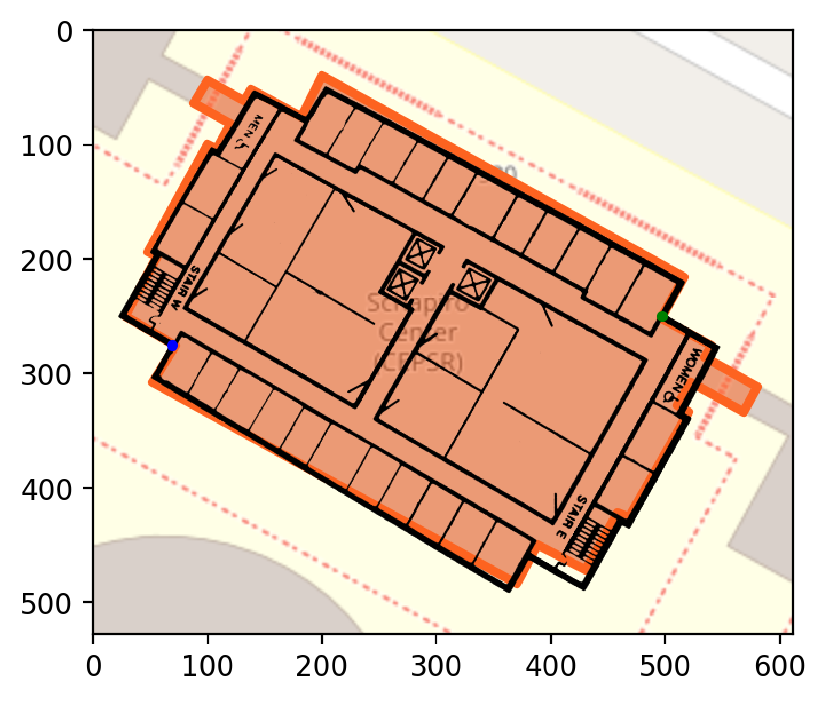

In [8]:
ref_a = ref[0]  # Bottom-left inner building corner
ref_b = ref[10] # Upper-right inner building corner

old = polyline2array([v.old for v in [ref_a, ref_b]])
new = polyline2array([v.new for v in [ref_a, ref_b]])

# Given the two reference points A and B, estimate the transformation that is
# needed to translate the floorplan's coordinates into mapview coordinates.
# Function estimate_transform estimates the scale, rotation, and translation
# factors and returns those in form of a transform matrix. 
#
# With only two reference points we cannot really estimate shear or skew and
# must use the simpler 'similarity' transform method instead of the more
# general 'affinnity' transform method.
#
# Internally, the function estimate_transform uses the least squares method
# to estimate the rotation, scale, and translation parameters using the given
# reference points.
#
# With only two reference points, the method used here is very similar to what
# the Java application is using. Thus, the image we get will be very similar 
# to what the Java application would produce in terms of fit.

transform = estimate_transform('similarity', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

# Draw both images over each other

plt.imshow(mapview)
plt.imshow(image)

# Highlight the two reference points

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)

Not very good fit. The mis-alignments in building corners are on the order of meters. Apart from the fact that the floorplan has a slightly different aspect ratio than the building in OpenStreetMap, the scanning distortion in the image also contributes to the mis-alignment. The result will be better or worse, dependind on what reference points are used, i.e., whether any of the reference points lies in the heavily distored part of the image.

A projective transformation could, in theory, compensate for some of scanning distortion found in the original image. We need 4 reference points to use a projective transformation reliably.

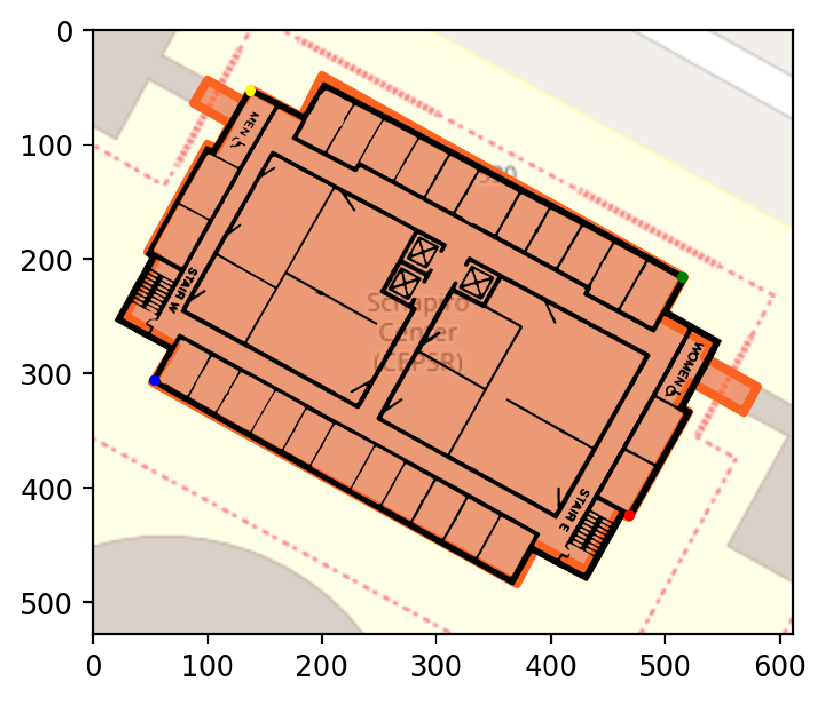

In [31]:
ref_a = ref[1]
ref_b = ref[11]
ref_c = ref[6]
ref_d = ref[14]

old = polyline2array([v.old for v in [ref_a, ref_b, ref_c, ref_d]])
new = polyline2array([v.new for v in [ref_a, ref_b, ref_c, ref_d]])

transform = estimate_transform('projective', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)
plt.plot(*ref_c.new, color="red", marker='o', markersize=3)
plt.plot(*ref_d.new, color="yellow", marker='o', markersize=3)

The fit is significantly better. The distortion is still visible in the upper-left corner, but its effect has been considerably diminished. If we choose the upper-left outer building corner as a reference point, e.g., instead of the yellow reference point, the result would probably improve some more.

Finally, here is a fit obtained by using all 10 building corners as reference points and a projective transformation.

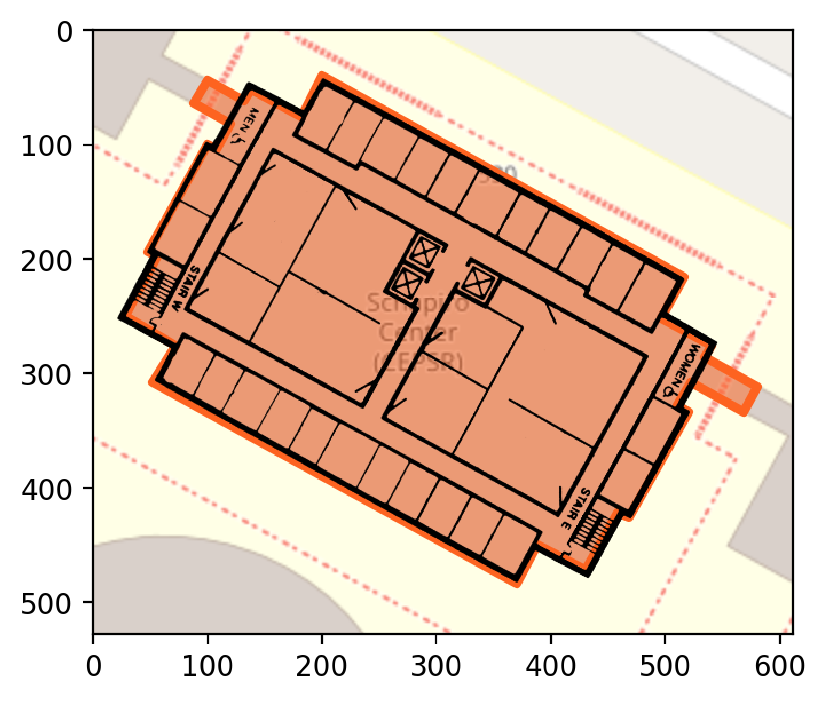

In [33]:
old = polyline2array([v.old for v in ref])
new = polyline2array([v.new for v in ref])

transform = estimate_transform('projective', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

Pretty perfect again. The scanning distortion is no longer visible. The only downside is that the user would need to align 10 reference points in the Java editor instead of just 2. If we can obtain the building model from OpenStreetMap automatically and provide some simple UI for the user to do it, it might be workable.

Let's show that this kind of transformation is usable with polygons, too. Here are three polygons for Henning's office, the IRT lab, and Costa Commons.

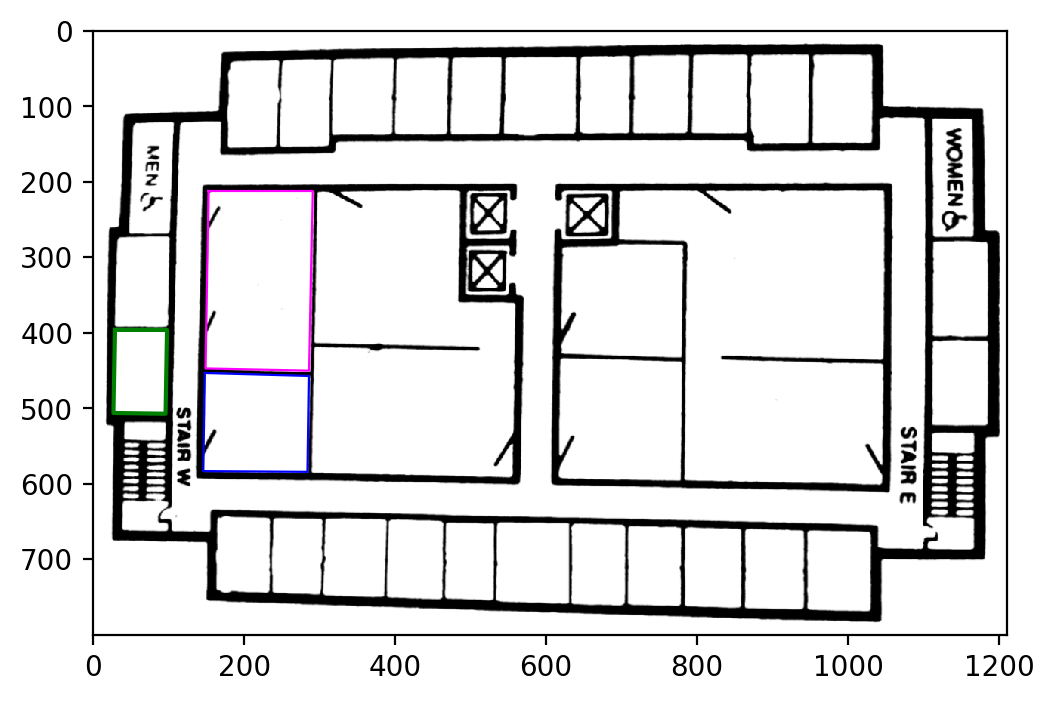

In [34]:
# Room 7LW2 a.k.a. IRT lab
irt = [Point(148, 453), Point(286, 457), Point(284, 584), Point(146, 583)]

# Room 750 a.k.a. Costa Commons
costa = [Point(153, 212), Point(291, 212), Point(286, 450), Point(149, 447)]

# Room 720 a.k.a. Henning's office
hgs = [Point(29, 396), Point(98, 396), Point(96, 507), Point(27, 506)]

# Reference point A, one of the corners of CEPSR for which we can obtain longitude,latitude from OpenStreetMap
ref_a = RefPoint(Point(161,  697), Point(69, 275))

# Reference point A, a corner of CEPSR on the other side of the building
ref_b = RefPoint(Point(1040, 106), Point(497, 250))
          
plt.plot(*plot(polygon(irt)), linewidth=0.8, color="blue")
plt.plot(*plot(polygon(costa)), linewidth=0.8, color="magenta")
plt.plot(*plot(polygon(hgs)), color="green")

plt.imshow(floorplan)

And the following picture shows the full transformation.

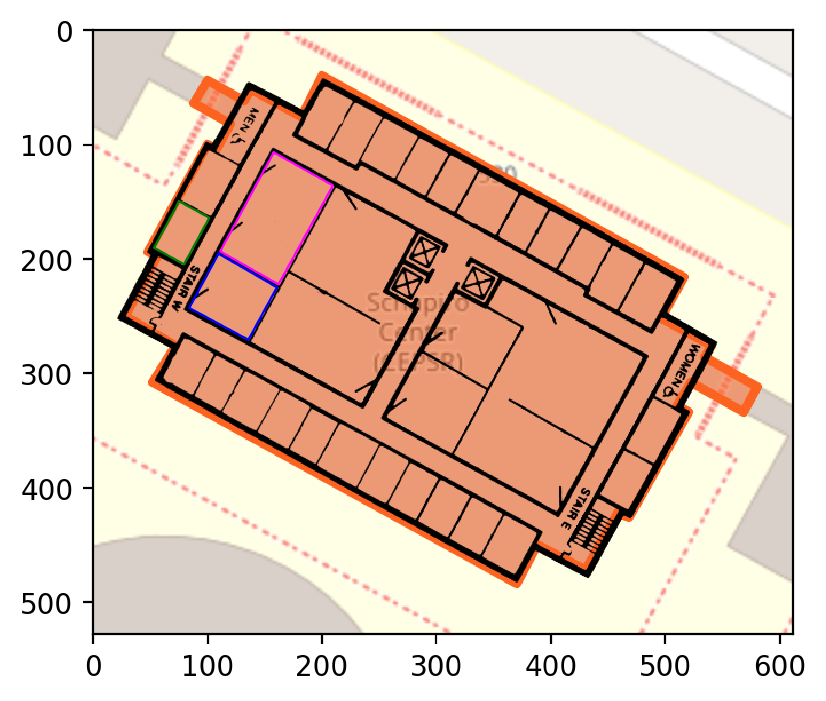

In [56]:
old = polyline2array([v.old for v in ref])
new = polyline2array([v.new for v in ref])

transform = estimate_transform('projective', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

h, w, _ = floorplan.shape
coords = warp_coords(transform, shape=(h, w))

def transform(polyline):
    return [Point(coords[1][p.y][p.x], coords[0][p.y][p.x]) for p in polyline]

plt.plot(*plot(polygon(transform(irt))), linewidth=0.8, color="blue")
plt.plot(*plot(polygon(transform(costa))), linewidth=0.8, color="magenta")
plt.plot(*plot(polygon(transform(hgs))), linewidth=0.8, color="green")